In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn import preprocessing
import seaborn as sns

In [2]:
train = pd.read_excel(r'C:/Users/198353/Downloads/Flight_Ticket_Hack/Data_Train.xlsx')
test = pd.read_excel(r'C:/Users/198353/Downloads/Flight_Ticket_Hack/Test_set.xlsx')

In [3]:
y = train.iloc[:,-1]

In [4]:
#total = train.append(test,ignore_index = True)
total = pd.concat( [train,test], axis = 0, ignore_index = 'True', sort= False)  #sort = False prevented sorting of column
total = total.iloc [:,0:10]
total.info()
total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13134 entries, 0 to 13133
Data columns (total 10 columns):
Airline            13134 non-null object
Date_of_Journey    13134 non-null object
Source             13134 non-null object
Destination        13134 non-null object
Route              13134 non-null object
Dep_Time           13134 non-null object
Arrival_Time       13134 non-null object
Duration           13134 non-null object
Total_Stops        13134 non-null object
Additional_Info    13134 non-null object
dtypes: object(10)
memory usage: 1.0+ MB


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info


In [5]:
import calendar
from datetime import datetime
total["weekday"] = total.Date_of_Journey.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%d/%m/%Y").weekday()])

In [6]:
total['weekend'] = total['weekday'].replace({ 'Sunday':1,'Saturday':1,
                                             'Monday':0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday': 0 })

In [7]:
test['ignore'] = 0 #for profiling test dataset

In [31]:
import pandas_profiling   # 220 duplicate rows removed from train, 26 from test were not touched
pandas_profiling.ProfileReport(test)

In [8]:
total['Destination'] = total['Destination'].replace('New Delhi', 'Delhi')
total['Additional_Info'] = total['Additional_Info'].replace('No Info', 'No info')

In [9]:
total['Destination'].value_counts()

Cochin       5491
Banglore     3570
Delhi        2734
Hyderabad     883
Kolkata       456
Name: Destination, dtype: int64

In [10]:
total['Total_Stops'] = total['Total_Stops'].replace({ 'non-stop':0,
                                                      '1 stop': 1,
                                                      '2 stops':2,
                                                    '3 stops':3,
                                                    '4 stops':4 })

# df['Stop'] = df['Total_Stops'].str.split(' ').str[0]      this could have been done instead after replacing non-stop with 0

In [11]:
total['Total_Stops'].value_counts()

1    7057
0    4324
2    1697
3      54
4       2
Name: Total_Stops, dtype: int64

In [12]:
total.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,weekday,weekend
0,IndiGo,24/03/2019,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,Sunday,1
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,Wednesday,0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,Sunday,1
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,Sunday,1
4,IndiGo,01/03/2019,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,Friday,0


In [13]:
import re   
duration = total["Duration"]

for string in duration:
    s = str(string)      # converts into string
    a = []
    a = re.findall('\d+', s)
    if len(a)==2:
       total["Duration"] = total["Duration"].replace(s,(int(a[0])*60)+int(a[1]))
    else:
       total["Duration"] = total["Duration"].replace(s, int(a[0])*60)

In [14]:
total['Arrival_Time'] = total['Arrival_Time'] .str.split(' ').str[0]

In [15]:
# keeping just the hour part of arrival and dep time
# replace is very slow, better with str.split()
'''
for string in total["Arrival_Time"]:                    
    s = str(string)
    a = []
    a = re.findall('\d+', s)
    total["Arrival_Time"] = total["Arrival_Time"].replace(s,a[0])
'''

total['Arrival_Hour'] = total['Arrival_Time'] .str.split(':').str[0]
total['Arrival_Min'] = total['Arrival_Time'] .str.split(':').str[1]

In [16]:
total['Dep_Hour'] = total['Dep_Time'] .str.split(':').str[0]
total['Dep_Min'] = total['Dep_Time'] .str.split(':').str[1]

In [17]:
total['Dep_Time'] = total['Dep_Time'] .str.split(':').str[0]
total["Dep_Time"] = total["Dep_Time"].astype(int)

In [18]:
for i in total['Dep_Time']:
    if i in range(5,10):
        total["Dep_Time"] = total["Dep_Time"].replace(i,'Morning')
    elif i in range(10,17):
        total["Dep_Time"] = total["Dep_Time"].replace(i,'Afternoon')
    elif i in range(17,22): 
        total["Dep_Time"] = total["Dep_Time"].replace(i,'Evening')
    elif i in range(22,24) or i in range(0,5):
        total["Dep_Time"] = total["Dep_Time"].replace(i,'Overnight')
        
# try and write this in a function

In [19]:
total['Date'] = total['Date_of_Journey'].str.split('/').str[0]
total['Month'] = total['Date_of_Journey'].str.split('/').str[1]
total = total.drop(['Date_of_Journey'], axis=1)
total = total.drop(['Arrival_Time'], axis=1)

In [20]:
total['Route'] = total['Route'].str.split('→ ')
# total['Route'].str.len()     this works too

In [21]:
total.dtypes

Airline            object
Source             object
Destination        object
Route              object
Dep_Time           object
Duration            int64
Total_Stops         int64
Additional_Info    object
weekday            object
weekend             int64
Arrival_Hour       object
Arrival_Min        object
Dep_Hour           object
Dep_Min            object
Date               object
Month              object
dtype: object

In [22]:
total.head()

,Airline,Source,Destination,Route,Dep_Time,Duration,Total_Stops,Additional_Info,weekday,weekend,Arrival_Hour,Arrival_Min,Dep_Hour,Dep_Min,Date,Month
0,IndiGo,Banglore,Delhi,"[BLR , DEL]",Overnight,170,0,No info,Sunday,1,01,10,22,20,24,03
1,Air India,Kolkata,Banglore,"[CCU , IXR , BBI , BLR]",Morning,445,2,No info,Wednesday,0,13,15,05,50,1,05
2,Jet Airways,Delhi,Cochin,"[DEL , LKO , BOM , COK]",Morning,1140,2,No info,Sunday,1,04,25,09,25,9,06
3,IndiGo,Kolkata,Banglore,"[CCU , NAG , BLR]",Evening,325,1,No info,Sunday,1,23,30,18,05,12,05
4,IndiGo,Banglore,Delhi,"[BLR , NAG , DEL]",Afternoon,285,1,No info,Friday,0,21,35,16,50,01,03


In [23]:
total = pd.get_dummies(total, columns=['Airline','Source','Destination','weekday','Additional_Info'])  # One Hot Encoding

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
var_mod = ['Dep_Time','Arrival_Hour','Route','Arrival_Min','Dep_Hour','Dep_Min','Date','Month','Total_Stops']
for i in var_mod:
           total[i] = le.fit_transform(total[i])

In [25]:
total.shape

(13134, 49)

In [26]:
df_train = pd.concat( [total[0:10463],y], axis = 1,sort= False) #ignore_index = 'False' removes the legends
df_test = total[10463:]

In [27]:
from sklearn.model_selection import train_test_split,GridSearchCV
xtrain, xtest, ytrain, ytest = train_test_split(total[0:10463],y, test_size=0.20, random_state = 10)

C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


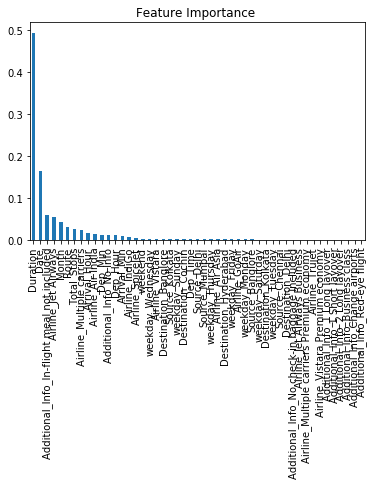

In [28]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100,max_depth= 20, min_samples_leaf= 10,n_jobs= -1,random_state= 100)
model_rf = rf.fit(xtrain, ytrain)

predictors = xtrain.columns
coef = pd.Series(model_rf.feature_importances_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importance ')

In [30]:
def selectKImportance(model, X, k):
     return X.loc[:,coef.index[0:k-1]]

In [31]:
new_xtrain = selectKImportance(model_rf,xtrain, 15)

In [29]:
grid_param = {  
    'n_estimators': [500, 1000, 1200],           # number of trees in the forest 
    'max_features': ['auto'],                   # number of features considered for splitting at each leaf node
    "max_depth": [5,10,15],                    # max number of levels in each decision tree
}

In [30]:
gd_sr = GridSearchCV(estimator= model_rf,  
                     param_grid= grid_param,
                     cv= 5,
                     n_jobs=-1)

In [31]:
gd_sr.fit(xtrain, ytrain)  

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [500, 1000, 1200], 'max_features': ['auto'], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
best_parameters = gd_sr.best_params_  
print(best_parameters) 

{'max_depth': 15, 'max_features': 'auto', 'n_estimators': 1000}


In [33]:
best_result = gd_sr.best_score_  
print(best_result) 

0.8077948523332715


In [34]:
grid_param.update(gd_sr.best_params_)

In [35]:
model = RandomForestRegressor(**grid_param)

In [36]:
model.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [37]:
prediction_rf = model.predict(xtest)

In [32]:
#xgboost

params = {
     'learning_rate': [0.1],
     'min_child_weight': [3,5], #1-3
     'n_estimators': [1000],
     'max_depth':range(2,10,2)       
     
    } 

In [33]:
model2 = xgb.XGBRegressor()
gsearch = GridSearchCV(estimator = model2, param_grid = params, scoring = 'mean_squared_error', cv = 3, verbose = 1)

In [34]:
gsearch.fit(new_xtrain, ytrain)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in versi

C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\198353\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in versi

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1], 'min_child_weight': [3, 5], 'n_estimators': [1000], 'max_depth': range(2, 10, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mean_squared_error', verbose=1)

In [35]:
print("Best Parameters :",gsearch.best_params_)

Best Parameters : {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 1000}


In [36]:
params.update(gsearch.best_params_)

In [37]:
xgb_model = xgb.XGBRegressor(**params)

In [38]:
xgb_model.fit(new_xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [40]:
new_xtest = selectKImportance(model_rf,xtest, 15)

In [42]:
prediction_xgb = xgb_model.predict(new_xtest)

In [43]:
from sklearn.metrics import mean_squared_error                # for calculating RMSE
from math import sqrt                        

rms = sqrt(mean_squared_error(ytest,prediction_xgb))
print(rms)

1441.0023571721906


In [44]:
def rmsle(prediction, ytest):  # for rmsle
    return np.sqrt(np.mean(np.square(np.log1p(prediction) - np.log1p(ytest))))

In [45]:
print(rmsle(prediction_xgb, ytest))

0.14339708649225671


In [57]:
price = xgb_model.predict(df_test)

In [59]:
df = pd.DataFrame({"Price":price})
df.head()  

,Price
0,14215.710938
1,4268.073242
2,12836.103516
3,13413.554688
4,3578.621582


In [60]:
df.to_excel("submit_xgb.xlsx")